In [1]:
from __future__ import division
import os
import math
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pylab
from matplotlib import rc
import pandas as pd
import scipy.stats as stats

from sklearn.decomposition import PCA
from IPython.html.widgets import interact
from IPython.html import widgets
from IPython.display import display

from clustering import cluster_pathway_score, combined_heatmap
from survival import survival_analysis
from clean_data import CANCER_TYPES

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:

def KM(memb, clinical_df, cancer_type, clusters, drop=''):
    memb = memb.copy()
    clusts = [int(x) for x in str(clusters)]
    rest = list(set(memb.unique()).difference(clusts))

    if drop and drop > 0:    
        ignore = [int(x) for x in str(drop)]
        memb = memb[~memb.isin(ignore)]
    if drop and drop < 0:    
        ignore = rest
        memb = memb[~memb.isin(ignore)]


    memb[memb.isin(rest)] = rest[0]
#     print memb.value_counts()
    clinical_df = clinical_df.join(memb, how='inner', lsuffix='old')
    survival_analysis(clinical_df, title=cancer_type)
    
    
    return memb, clinical_df




In [3]:
can_types = []
for c in CANCER_TYPES:
    f1 = '../results/' + c + os.sep + 'silent_mutation_pathway_score.txt'
    f2 = '../results/' + c + os.sep + 'nsilent_mutation_pathway_score.txt'
    f3 = '../data/processed/' + c + os.sep + c + '_clinical.csv'

    if os.path.exists(f1) and os.path.exists(f2) and os.path.exists(f3):
        can_types.append(c)
    
print "There are %d cancer types ready to be analysed" % len(can_types)
can_type_wid = widgets.Dropdown(description="Select Cancer Type", options=can_types)
display(can_type_wid)



There are 25 cancer types ready to be analysed


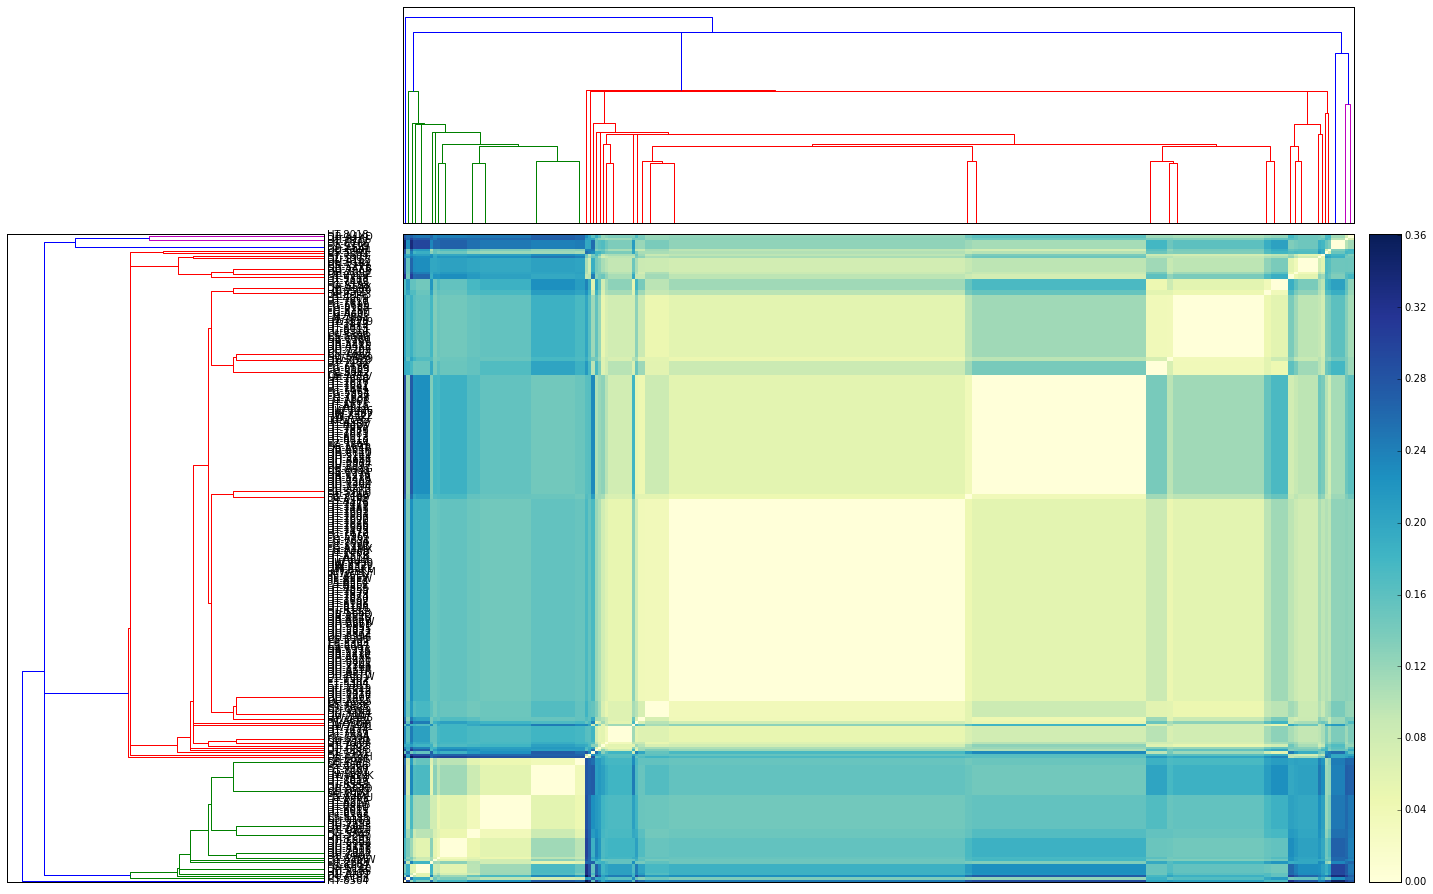

3     207
1      52
4      11
8       4
9       3
5       2
10      1
7       1
6       1
2       1
dtype: int64


In [20]:
cancer_type = can_type_wid.value
memb, clinical_df, df = cluster_pathway_score(cancer_type)
print memb.value_counts()

(283, 7)


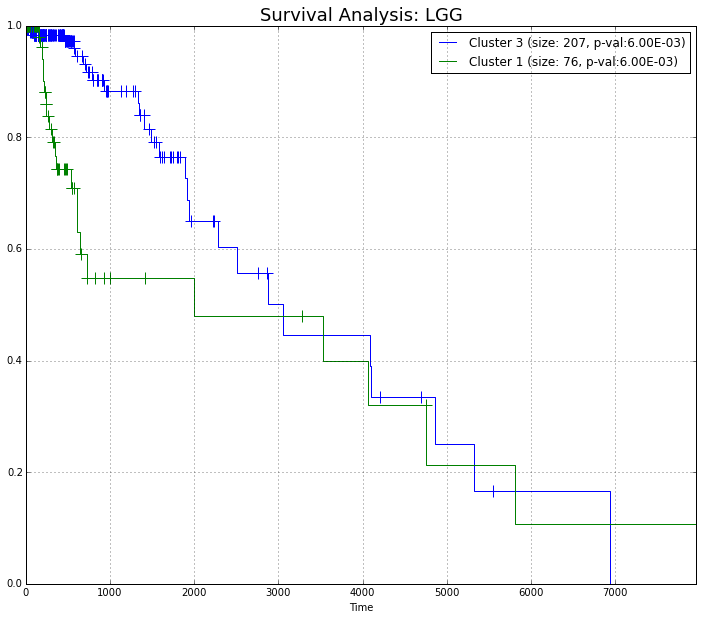

In [21]:
print clinical_df.shape
idx, clinical_df = KM(memb, clinical_df, cancer_type, 3)
# print memb.value_counts()

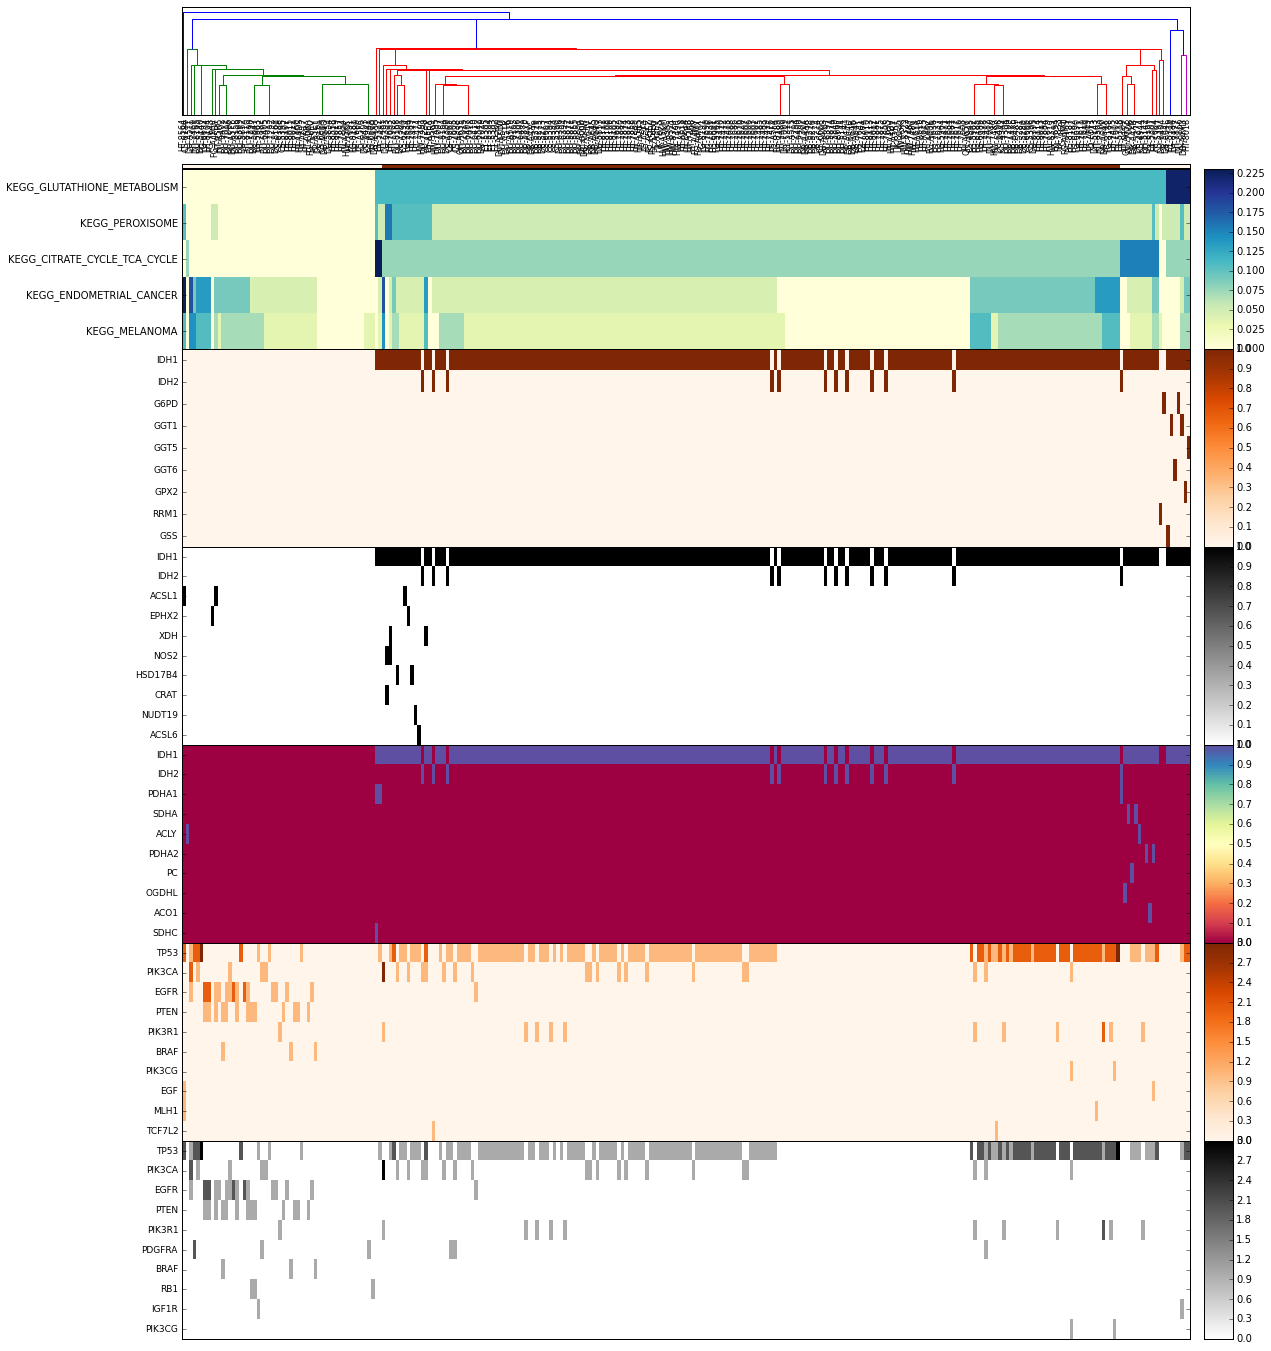

In [22]:
idx = combined_heatmap(cancer_type, num_pathways=5, num_genes=10, groups=clinical_df['groups']);

In [7]:
# # http://en.wikipedia.org/wiki/DNA_codon_table
# amino_acids = 'arndcqeghi'
# amino_acids += 'lkmfpstwyv'
# amino_acids += 'bo'
# codons = '4622222423'
# codons += '6212464124'
# codons += '13'
# spr = 1; nspr = 1;
# spr =  sum([int(x)-1 for x in codons])/(22*27)
# nspr = 1 - spr



In [8]:
def preprocess_pathway_data():
    """Load GSEA MSigDB Broad Pathway DB"""
    input_dir = '../data/pathways'
    filename = input_dir + os.sep + 'kegg_biocarta_pid_positional.txt'
    pathways = {}
    with open(filename, 'r') as f:
        for line in f:
            p = line.strip().split('\t')
            pathways[p[0]] = p[2:]

    df = pd.DataFrame.from_dict(pathways, orient='index').transpose()

    return df

In [9]:
df = preprocess_pathway_data()
df.count().describe()

count    925.000000
mean      60.315676
std       72.008431
min        5.000000
25%       22.000000
50%       39.000000
75%       70.000000
max      948.000000
dtype: float64